<center>
    <p style="text-align:center">
    <img alt="arize logo" src="https://storage.googleapis.com/arize-assets/arize-logo-white.jpg" width="300"/>
        <br>
        <a href="https://docs.arize.com/arize/">Docs</a>
        |
        <a href="https://github.com/Arize-ai/client_python">GitHub</a>
        |
        <a href="https://arize-ai.slack.com/join/shared_invite/zt-11t1vbu4x-xkBIHmOREQnYnYDH1GDfCg">Slack Community</a>
    </p>
</center>

</center>
<h1 align="center">Model Comparison for an Email Text Extraction Service</h1>

Imagine you're deploying a service that condenses emails into concise summaries. One challenge of using LLMs for summarization is that even the best models can miscategorize key details, or miss those details entirely.

In this tutorial, you will construct a dataset and run experiments to engineer a prompt template that accurately summarizes your emails. You will:

- Upload a **dataset** of **examples** containing emails to Arize
- Define an **experiment task** that extracts and formats the key details from those emails
- Devise an **evaluator** measuring Jaro-Winkler Similarity
- Run **experiments** to iterate on your prompt template and to compare the summaries produced by different LLMs

⚠️ This tutorial requires and OpenAI API key.

Let's get started!

In [ ]:
!pip install -qq "arize-otel>=0.7.0" "arize-phoenix-evals>=0.17.5" "arize[Datasets]>=7.29.0"

!pip install -qq "openinference-instrumentation-langchain>=0.1.29" "openinference-instrumentation-openai>=0.1.18"

!pip install -qq langchain==0.3.10 langchain-core==0.3.24 langchain-community==0.3.10 langchain-benchmarks==0.0.10 langchain-openai==0.2.12 nest_asyncio==1.6.0 jarowinkler==2.0.1 pandas==2.2.3

# Set Up Environment Variables

In [ ]:
import os
from getpass import getpass

space_id = "INPUT_YOUR_SPACE_ID"  # Input your space ID

if not os.getenv("ARIZE_API_KEY"):
    os.environ["ARIZE_API_KEY"] = getpass("🔑 Enter your Arize API key: ")

api_key = os.environ["ARIZE_API_KEY"]

if not os.getenv("DEVELOPER_KEY"):
    os.environ["DEVELOPER_KEY"] = getpass("🔑 Enter your Arize Developer key: ")

developer_key = os.environ["DEVELOPER_KEY"]

if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass("🔑 Enter your OpenAI API key: ")

openai_api_key = os.environ["OPENAI_API_KEY"]

# Import Modules

In [ ]:
import json
import tempfile
from datetime import datetime, timezone

import jarowinkler
import nest_asyncio
import pandas as pd
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_benchmarks import download_public_dataset, registry
from langchain_openai.chat_models import ChatOpenAI
from openinference.instrumentation.langchain import LangChainInstrumentor
from openinference.instrumentation.openai import OpenAIInstrumentor

from arize.otel import register

nest_asyncio.apply()

# Instrument LangChain and OpenAI

In [ ]:
# Set up OTEL via our convenience function
space_id = space_id
tracer_provider = register(
    space_id=space_id,  # in app space settings page
    api_key=api_key,  # in app space settings page
    model_id="email-extraction-experiment",
)

# Set up automatic instrumentation
LangChainInstrumentor().instrument(
    skip_dep_check=True, tracer_provider=tracer_provider
)
OpenAIInstrumentor().instrument(
    skip_dep_check=True, tracer_provider=tracer_provider
)

# Experiments in Arize

Experiments are made up of 3 elements: a dataset, a task, and an evaluator. The dataset is a collection of the inputs and expected outputs that we'll use to evaluate. The task is an operation that should be performed on each input. Finally, the evaluator compares the result against an expected output.

For this example, here's what each looks like:
*   Dataset - a dataframe of emails to analyze, and the expected output for our agent
*   Task - a langchain agent that extracts key info from our input emails. The result of this task will then be compared against the expected output
*   Eval - Jaro-Winkler distance calculation on the task's output and expected output

# Download JSON Data

We've prepared some example emails and actual responses that we can use to evaluate our two models. Let's download those and save them to a temporary file.

In [ ]:
dataset_name = "Email Extraction"

with tempfile.NamedTemporaryFile(suffix=".json") as f:
    download_public_dataset(registry[dataset_name].dataset_id, path=f.name)
    df = pd.read_json(f.name)[["inputs", "outputs"]]
df = df.sample(10, random_state=42)
df

Format the dataframe for import into Arize

In [ ]:
# Function for


def create_columns(row):
    row["inputs"] = json.dumps(
        row["inputs"]["input"]
    )  # Extracts the input text as a string
    row["outputs"] = json.dumps(
        row["outputs"]["output"]
    )  # Extracts the output dictionary as a string
    return row

In [ ]:
# Create a formatted dataframe for Arize dataset creation (inputs and outputs columns with string values)

df_original = df.copy()
df_formatted = df_original.apply(create_columns, axis=1)
df_formatted

# Upload Dataset to Arize

In [ ]:
import pandas as pd
from arize.experimental.datasets import ArizeDatasetsClient
from arize.experimental.datasets.utils.constants import GENERATIVE

arize_client = ArizeDatasetsClient(developer_key=developer_key, api_key=api_key)

In [ ]:
dataset_id = arize_client.create_dataset(
    space_id=space_id,
    dataset_name=f"{dataset_name}{datetime.now(timezone.utc)}",
    dataset_type=GENERATIVE,
    data=df_formatted,
)

# Export Dataset from Arize

In [ ]:
dataset = arize_client.get_dataset(
    space_id=space_id, dataset_id=dataset_id
)  # Export dataset that we just created from Arize

In [ ]:
dataset["inputs"] = dataset["inputs"].apply(
    lambda x: json.loads(x)
)  # Format inputs column values as a dictionary

# Set Up LangChain

Now we'll set up our Langchain agent. This is a straightforward agent that makes a call to our specified model and formats the response as JSON.

In [ ]:
model = "gpt-4o"  # Using gpt-4o for the first experiment

llm = ChatOpenAI(model=model).bind_functions(
    functions=[registry[dataset_name].schema],
    function_call=registry[dataset_name].schema.schema()["title"],
)
output_parser = JsonOutputFunctionsParser()
extraction_chain = registry[dataset_name].instructions | llm | output_parser

# Define Task Function

Next, we need to define a Task for our experiment to use.

In [ ]:
def task(example) -> str:
    input = example.get("inputs")
    return extraction_chain.invoke(input)

# Check that the task is working by running it on at least one Example

In [ ]:
first_example = dataset.iloc[0]  # First example in the dataset

task(first_example)

# Define Evaluator

Next, we need to define our evaluation function. Here we'll use a Jaro-Winkler similarity function that generates a score for how similar the output and expected text are. Jaro-Winkler similarity is technique for measuring edit distance between two strings.

In [ ]:
def jarowinkler_similarity(dataset_row, output) -> float:
    return jarowinkler.jarowinkler_similarity(
        json.dumps(dataset_row["outputs"], sort_keys=True),
        json.dumps(output, sort_keys=True),
    )

# Run Experiment

Now we're ready to run our experiment. We'll specify our space id, dataset id, task, evaluator, and experiment name in order to generate and evaluate responses.

In [ ]:
experiment = arize_client.run_experiment(
    space_id=space_id,
    dataset_id=dataset_id,
    task=task,
    evaluators=[jarowinkler_similarity],
    experiment_name="email_text_extraction_gpt-4o_experiment",
)

Now we have scores on how well GPT-4o does at extracting email facts. This is helpful, but doesn't mean much on its own. Let's compare it against another model.

# Re-run with GPT 3.5 Turbo and Compare Results

To compare results with another model, we simply need to redefine our task. Our dataset and evaluator can stay the same.

In [ ]:
model = "gpt-3.5-turbo"

llm = ChatOpenAI(model=model).bind_functions(
    functions=[registry[dataset_name].schema],
    function_call=registry[dataset_name].schema.schema()["title"],
)
extraction_chain = registry[dataset_name].instructions | llm | output_parser

In [ ]:
experiment = arize_client.run_experiment(
    space_id=space_id,
    dataset_id=dataset_id,
    task=task,
    evaluators=[jarowinkler_similarity],
    experiment_name="email_text_extraction_gpt-35-turbo_experiment",
)

# View results

Now, if you check your Arize experiments, you can compare Jaro-Winkler scores on a per query basis, and view aggregate model performance results.

The first screenshot below shows a comparison between the average Jaro-Winkler scores for the two experiments we ran.

The second screenshot shows a detailed view of each row's individual Jaro-Winkler score for both experiments. The experiment with GPT-4o is on the left (experiment #1) and the experiment with GPT-3.5-turbo is on the right (experiment #2). The higher the Jaro-Winkler similarity score, the closer the outputted value is to the actual value.

**You should see that GPT-4o outperforms its older cousin.**

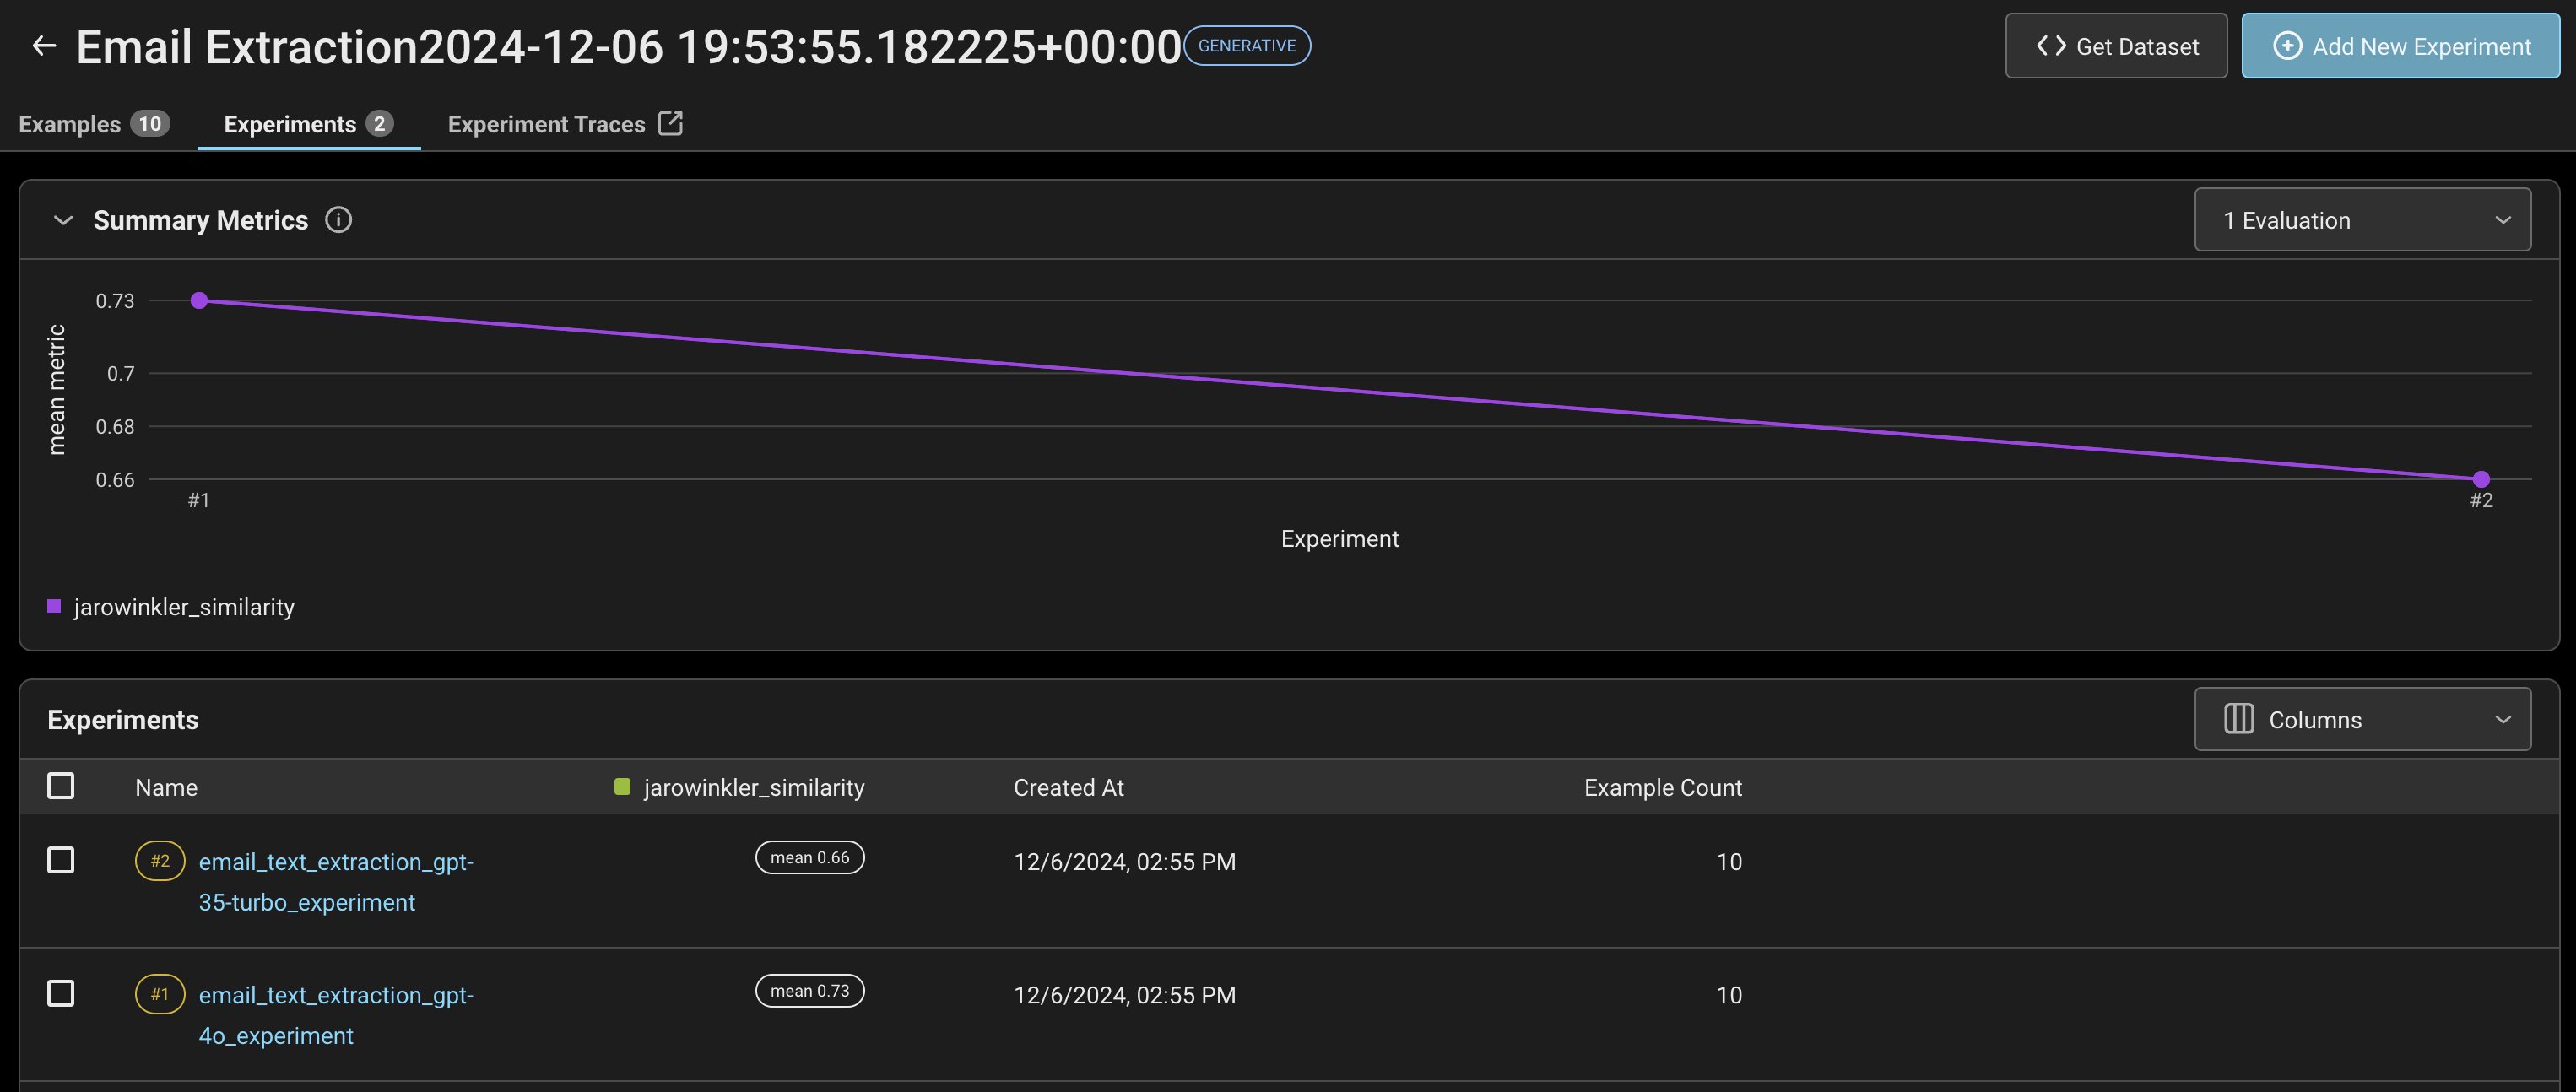

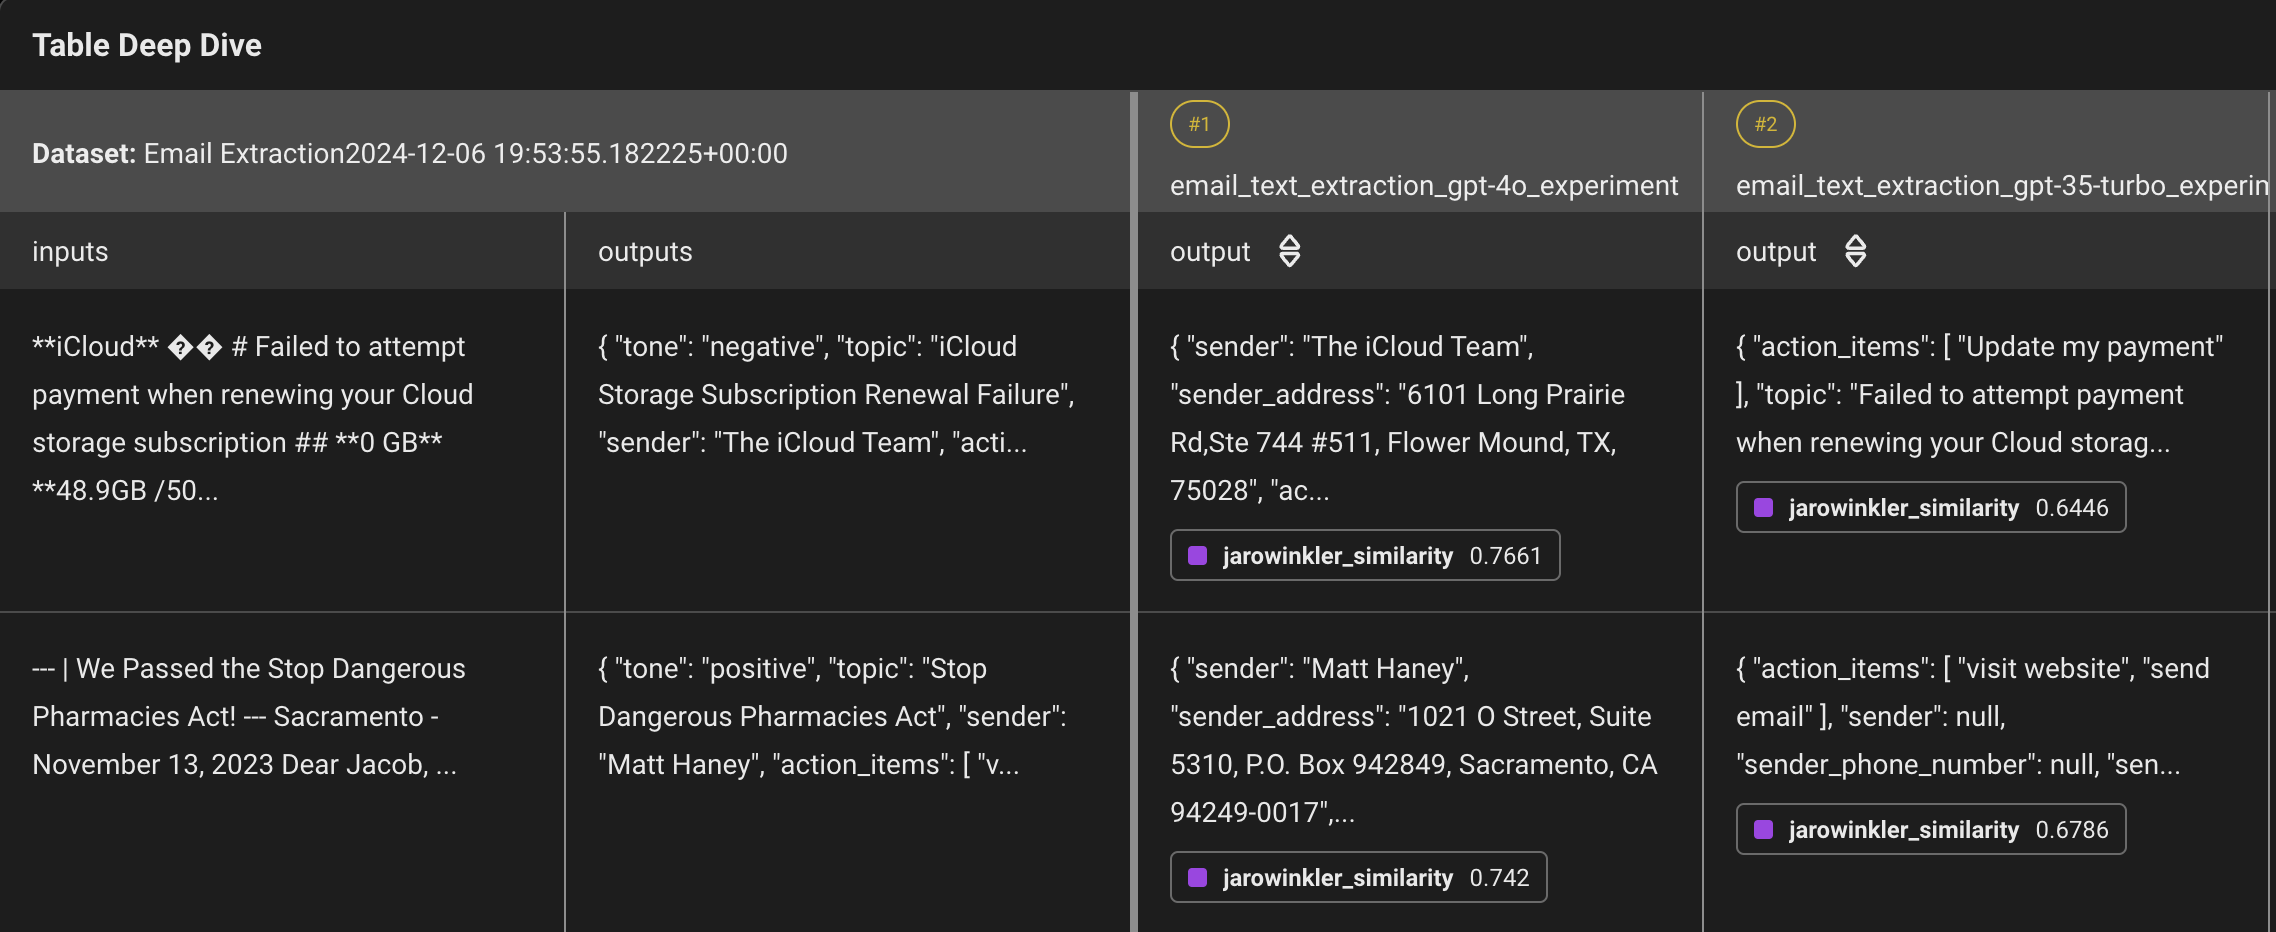